# Setup

In [19]:
import matplotlib.pyplot as plt
import numpy as np
from read_msc import *
import pickle
from ipywidgets import interact

## Pretty Colors

In [3]:
light_red = '#fbb4ae'
red = '#e41a1c'

light_blue = '#b3cde3'
blue = '#377eb8'

light_green = '#ccebc5'
green = '#4daf4a'

light_purple = '#decbe4'
purple = '#984ea3'

light_orange = '#fed9a6'
orange = '#ff7f00'

light_palette = [light_red, light_blue, light_green, light_purple, light_orange]
bold_palette = [red, blue, green, purple, orange]

## Reusable Variables and Functions

In [13]:
def show_image(image):
    plt.figure(num=None, dpi=200)
    plt.imshow(image, cmap=plt.cm.Greys_r)
    plt.axis('off')

def show_training_samples(image, in_samples, out_samples):
    show_image(image)
    plt.scatter(in_samples[:, 0], in_samples[:, 1], color=orange, s=1, marker=',')
    plt.scatter(out_samples[:, 0], out_samples[:, 1], color=purple, s=1, marker=',')

def show_classifier_result(compiled_data, classifier):
    flattened_data = compiled_data.reshape(-1, compiled_data.shape[-1])
    predicted_labels = classifier.predict(flattened_data)
    predicted_labels = predicted_labels.reshape(compiled_data.shape[0], compiled_data.shape[1])
    show_image(predicted_labels)
    
def show_morse_smale(image, msc):
    fig = plt.figure(num=None, dpi=200)
    plt.imshow(image, cmap=plt.cm.Greys_r, zorder=1)

    arc_mask = np.zeros(image.shape)

    for a in msc.arcs:
        arc_index = tuple(a.node_ids)
        points = np.array(a.line)
        for pt in points:
            arc_mask[int(pt[1]), int(pt[0])] = 1

    arc_mask = np.ma.masked_where(arc_mask == 0, arc_mask)
    plt.imshow(arc_mask, cmap='Oranges', vmin=0, vmax=4, interpolation='none', alpha=0.75, zorder=2)

    extrema_points = [[], [], []]
    for node in msc.nodes.values():
        x, y = node.xy
        extrema_points[node.index].append([x, y])

    for i, color in enumerate([blue, green, red]):
        xy = np.array(extrema_points[i])
        plt.scatter(xy[:, 0], xy[:, 1], facecolor=color, edgecolor='none', s=1, marker=',', zorder=4)

    plt.gca().set_xlim(0, image.shape[1])
    plt.gca().set_ylim(image.shape[0], 0)

# Load Precomputed Data

## Load Image and Filters

In [5]:
fname_base = 'max_diadem_smoothed'
compiled_data = np.load(fname_base + '_input.npy')

with open(fname_base + '_dimensions.txt', 'r') as f:
    dimensions = [line.strip() for line in f]

## Load Morse-Smale Complex

In [14]:
fname_raw = fname_base + ".raw"
msc = MSC()
msc.read_from_file(fname_raw)

## Load Pickled Model

In [16]:
f = open('logit.pk', 'rb')
model = pickle.load(f)
f.close()

## Visually Verify Everything Loaded Properly

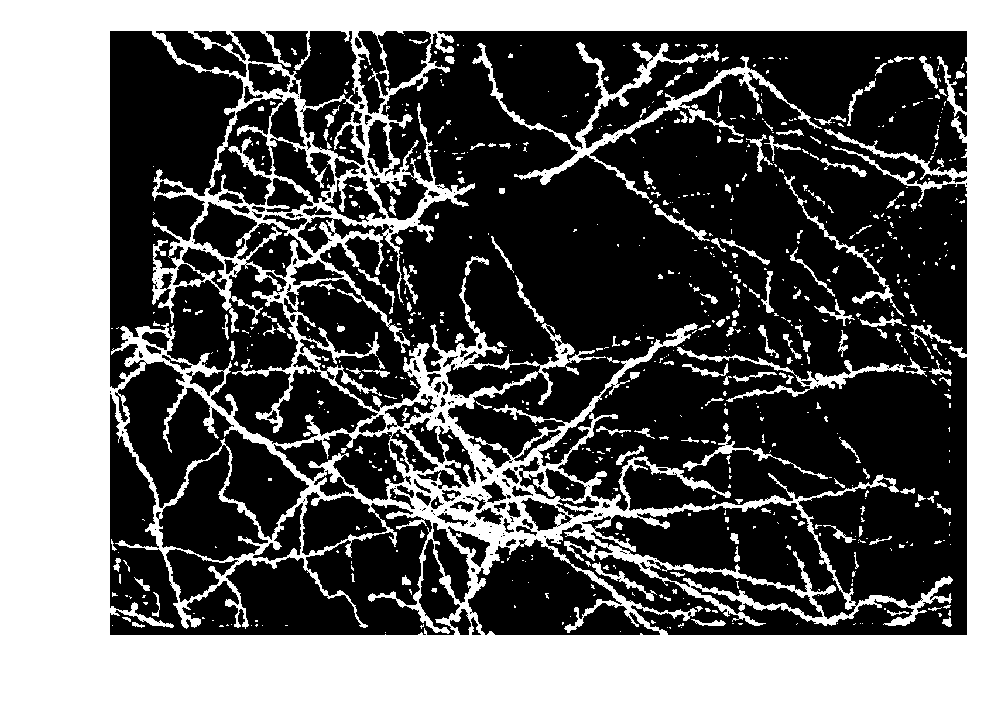

In [17]:
show_classifier_result(compiled_data, model)

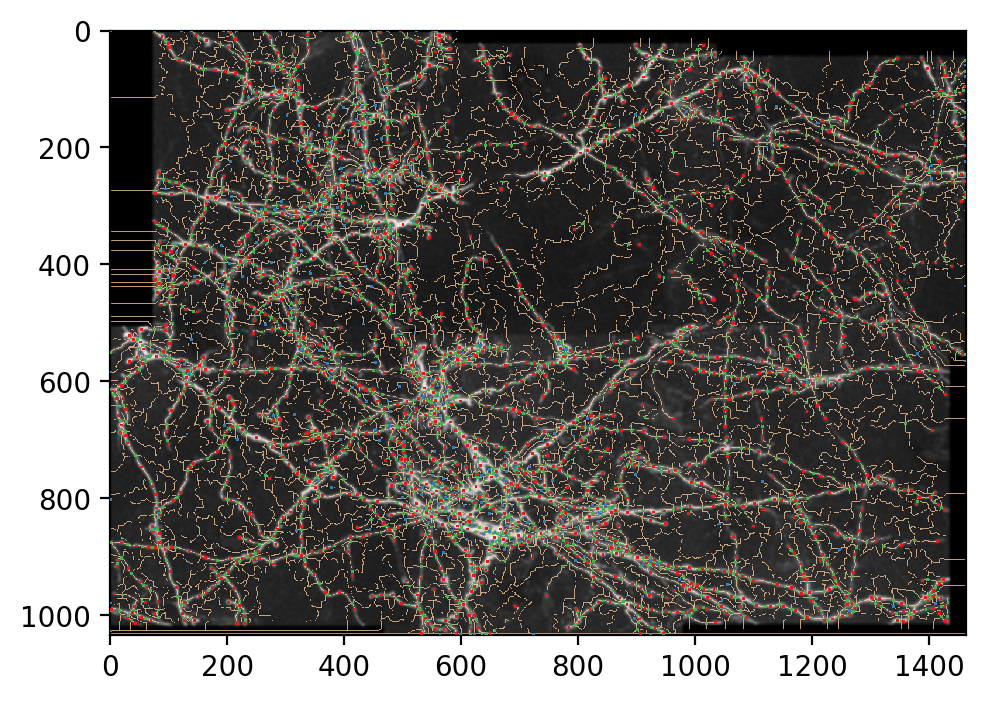

In [15]:
show_morse_smale(compiled_data[:,:,0], msc)

# Prune the Morse-Smale Complex

In [28]:
image = compiled_data[:, :, 0]

# Fraction of points on an arc that need to be above the threshold
@interact(threshold=(0.0, 1.0))
def prune_msc(threshold):
    show_image(image)

    flattened_data = compiled_data.reshape(-1, compiled_data.shape[-1])
    predicted_labels = model.predict(flattened_data)
    predicted_labels = predicted_labels.reshape(compiled_data.shape[0], compiled_data.shape[1])

    arc_mask = np.zeros(image.shape)

    accepted_arcs = set()
    for a in msc.arcs:
        indices = np.flip(np.array(a.line, dtype=int), axis=1)
        count = 0
        for row, col in indices:
            count += predicted_labels[row, col]
        if (count / indices.shape[0]) > threshold:
            arc_index = tuple(a.node_ids)
            accepted_arcs.add(arc_index)
            points = np.array(a.line)
            for pt in points:
                arc_mask[int(pt[1]), int(pt[0])] = 1

    arc_mask = np.ma.masked_where(arc_mask == 0, arc_mask)
    plt.imshow(arc_mask, cmap='Oranges', vmin=0, vmax=2, interpolation='none', alpha=1, zorder=2)

    extrema_points = [[], [], []]
    for node in msc.nodes.values():
        if node.cellid in accepted_arcs:
            x, y = node.xy
            extrema_points[node.index].append([x, y])

    for i, color in enumerate([blue, green, red]):
        xy = np.array(extrema_points[i])
        if len(xy):
            plt.scatter(xy[:, 0], xy[:, 1], facecolor=color, edgecolor='none', s=1, marker=',', zorder=4)

    plt.gca().set_xlim(0, image.shape[1])
    plt.gca().set_ylim(image.shape[0], 0)
    

interactive(children=(FloatSlider(value=0.5, description='threshold', max=1.0), Output()), _dom_classes=('widg…